### **Exploring the effect of model size on the accuracy of chain of thought prompting**

This notebook explores **reasoning performance in large language models** using different prompting strategies.

- A subset of the **GSM8K** mathematical reasoning dataset is used for evaluation.  
- Several prompting strategies are compared:  
  - **Zero-shot**  
  - **Zero-shot + Chain of Thought (CoT)**  
  - **Few-shot**  
  - **Few-shot + Chain of Thought (CoT)**  
- Responses are collected and accuracy is measured across strategies.  
- Results are visualized with plots to analyze which approach performs better.  

The goal of this work is to study how **prompt engineering** and **Chain of Thought prompting** affect model reasoning capabilities.

**References**

- Jason Wei, Xuezhi Wang, Dale Schuurmans, Maarten Bosma, Brian Ichter, Fei Xia, Ed Chi, Quoc Le, Denny Zhou (2022). Chain-of-Thought Prompting Elicits Reasoning in Large Language Models.
arXiv preprint arXiv:2201.11903

- Takeshi Kojima, Shixiang Shane Gu, Machel Reid, Yutaka Matsuo, Yusuke Iwasawa (2022). Large Language Models are Zero-Shot Reasoners.
arXiv preprint arXiv:2205.11916

- Vizuara AI Labs - Youtube Channel


In [1]:
!pip install -q transformers datasets accelerate

In [2]:
from datasets import load_dataset

# Loaded a subset for faster experiments
gsm8k = load_dataset("gsm8k", "main", split="test[:50]")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

main/train-00000-of-00001.parquet:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

main/test-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

In [3]:
# Few-shot Chain of Thought prompt examples
few_shot_prefix = """Q: Emily has 3 apples. Her friend gives her 2 more. How many apples does Emily have now?
A: Emily starts with 3 apples. Her friend gives her 2 more. So, 3 + 2 = 5. The answer is 5.

Q: A pen costs 2 dollars. John buys 4 pens. How much does he pay?
A: Each pen costs 2 dollars. John buys 4 pens. So, 2 × 4 = 8. The answer is 8.

Q: Jake read 5 pages on Monday and 7 pages on Tuesday. How many pages did he read in total?
A: Jake read 5 pages on Monday and 7 on Tuesday. So, 5 + 7 = 12. The answer is 12.
"""

### Defined the function used to evaluate the models

In [4]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline
import torch
import re
import matplotlib.pyplot as plt

# ---- Device selection ----
if torch.cuda.is_available():
    DEVICE_STR = "cuda"
    PIPELINE_DEVICE = 0
    DTYPE = torch.float16
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    DEVICE_STR = "mps"
    PIPELINE_DEVICE = -1
    DTYPE = torch.float32
else:
    DEVICE_STR = "cpu"
    PIPELINE_DEVICE = -1
    DTYPE = torch.float32

def evaluate_model_fewshot(model_id):
    print(f"Evaluating {model_id} with few-shot CoT on {DEVICE_STR}...")

    tokenizer = AutoTokenizer.from_pretrained(model_id)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_id, dtype=DTYPE).to(DEVICE_STR)

    pipe = pipeline(
        "text2text-generation",
        model=model,
        tokenizer=tokenizer,
        max_new_tokens=128,
        device=PIPELINE_DEVICE
    )

    correct = 0
    total = 0
    for sample in gsm8k:
        question = sample["question"]
        gt_answer = sample["answer"].split("####")[-1].strip()

        prompt = few_shot_prefix + f"Q: {question}\nA:"
        output = pipe(prompt)[0]["generated_text"]

        match = re.search(r"(\d+(?:\.\d+)?)", output.replace(",", ""))
        if match:
            pred = match.group(1)
            if pred == gt_answer:
                correct += 1
        total += 1

    acc = correct / total if total else 0.0
    print(f"Accuracy: {acc:.2%}")
    return acc


In [5]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("MPS available:", hasattr(torch.backends, "mps") and torch.backends.mps.is_available())


CUDA available: True
MPS available: False


### Model Sizes and Plot

Evaluating google/flan-t5-small with few-shot CoT on cuda...


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Accuracy: 2.00%
Evaluating google/flan-t5-base with few-shot CoT on cuda...


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Device set to use cuda:0


Accuracy: 2.00%
Evaluating google/flan-t5-large with few-shot CoT on cuda...


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Device set to use cuda:0


Accuracy: 2.00%


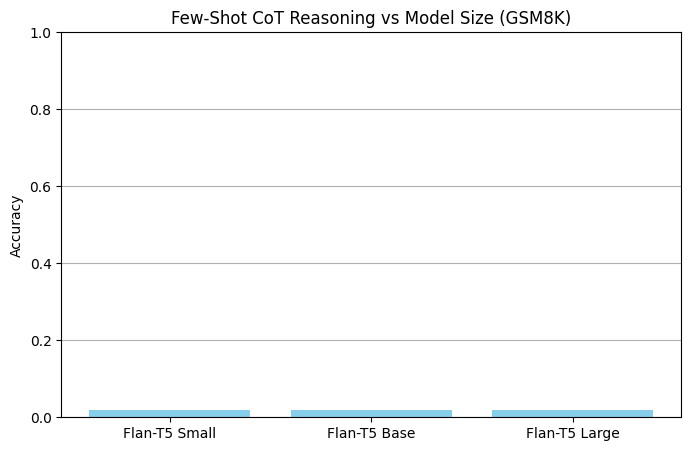

In [6]:
model_ids = {
    "Flan-T5 Small": "google/flan-t5-small",
    "Flan-T5 Base": "google/flan-t5-base",
    "Flan-T5 Large": "google/flan-t5-large"
}

results = []
for label, model in model_ids.items():
    acc = evaluate_model_fewshot(model)
    results.append((label, acc))

# Plotting
labels = [r[0] for r in results]
scores = [r[1] for r in results]
x = range(len(labels))

plt.figure(figsize=(8,5))
plt.bar(x, scores, color="skyblue")
plt.xticks(x, labels)
plt.ylabel("Accuracy")
plt.title("Few-Shot CoT Reasoning vs Model Size (GSM8K)")
plt.ylim(0, 1.0)
plt.grid(True, axis='y')
plt.show()

In [7]:
gsm8k_five = gsm8k.select(range(5))

def print_gsm8k_predictions(model_id, dataset, few_shot_prefix, decoder_only=False):
    from transformers import (
        AutoTokenizer,
        AutoModelForSeq2SeqLM,
        AutoModelForCausalLM,
        pipeline
    )
    import re
    import torch

    # Loaded appropriate model
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    if decoder_only:
        model = AutoModelForCausalLM.from_pretrained(
            model_id,
            device_map="auto",
            torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32
        )
        task = "text-generation"
    else:
        model = AutoModelForSeq2SeqLM.from_pretrained(model_id)
        task = "text2text-generation"

    pipe = pipeline(task, model=model, tokenizer=tokenizer, max_new_tokens=128, temperature=0.3)

    def extract_answer(text):
        text = text.replace(",", "")
        numbers = re.findall(r"[-+]?\d+(?:\.\d+)?", text)
        return numbers[-1] if numbers else None

    for i, sample in enumerate(dataset):
        question = sample["question"]
        gt_answer = sample["answer"].split("####")[-1].strip()

        prompt = few_shot_prefix + f"\nQ: {question}\nA:"
        output = pipe(prompt)[0]["generated_text"]
        if decoder_only:
            output_text = output.split("A:")[-1].strip()
        else:
            output_text = output.strip()

        pred = extract_answer(output_text)

        print(f"\n🔹 Example {i + 1}")
        print(f"Q: {question}")
        print(f"GT Answer: {gt_answer}")
        print(f"Model Output:\n{output_text}")
        print(f"Extracted Answer: {pred}")


print_gsm8k_predictions("google/flan-t5-base", gsm8k_five, few_shot_prefix, decoder_only=False)

Device set to use cuda:0
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



🔹 Example 1
Q: Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder at the farmers' market daily for $2 per fresh duck egg. How much in dollars does she make every day at the farmers' market?
GT Answer: 18
Model Output:
First find the total number of eggs Janet lays: 16 eggs / duck = 8 eggs / day. Then find the total number of muffins she bakes: 4 muffins / day * 4 muffins / day = 16 muffins / day. Then find the total number of eggs she sells at the farmers' market: 8 eggs / day + 16 muffins / day = 24 eggs / day. Then find the total number of eggs she sells at the farmers' market: 24 eggs / day + 16 muffins / day = 36 eggs /
Extracted Answer: 36

🔹 Example 2
Q: A robe takes 2 bolts of blue fiber and half that much white fiber.  How many bolts in total does it take?
GT Answer: 3
Model Output:
First find the total number of bolts of blue fiber: 2 bolts / 2 = 2 bolts of white fiber. T

## The Observation

The accuracy for these Flan Models are not good.

Why: Because smaller models do not perform well on arithmetic datasets.

 Have a look at the following graph from the paper on Chain of Thought Reasoning:

 The paper : [Scaling LLM Test-Time Compute Optimally can
be More Effective than Scaling Model Parameters](https://arxiv.org/pdf/2408.03314)

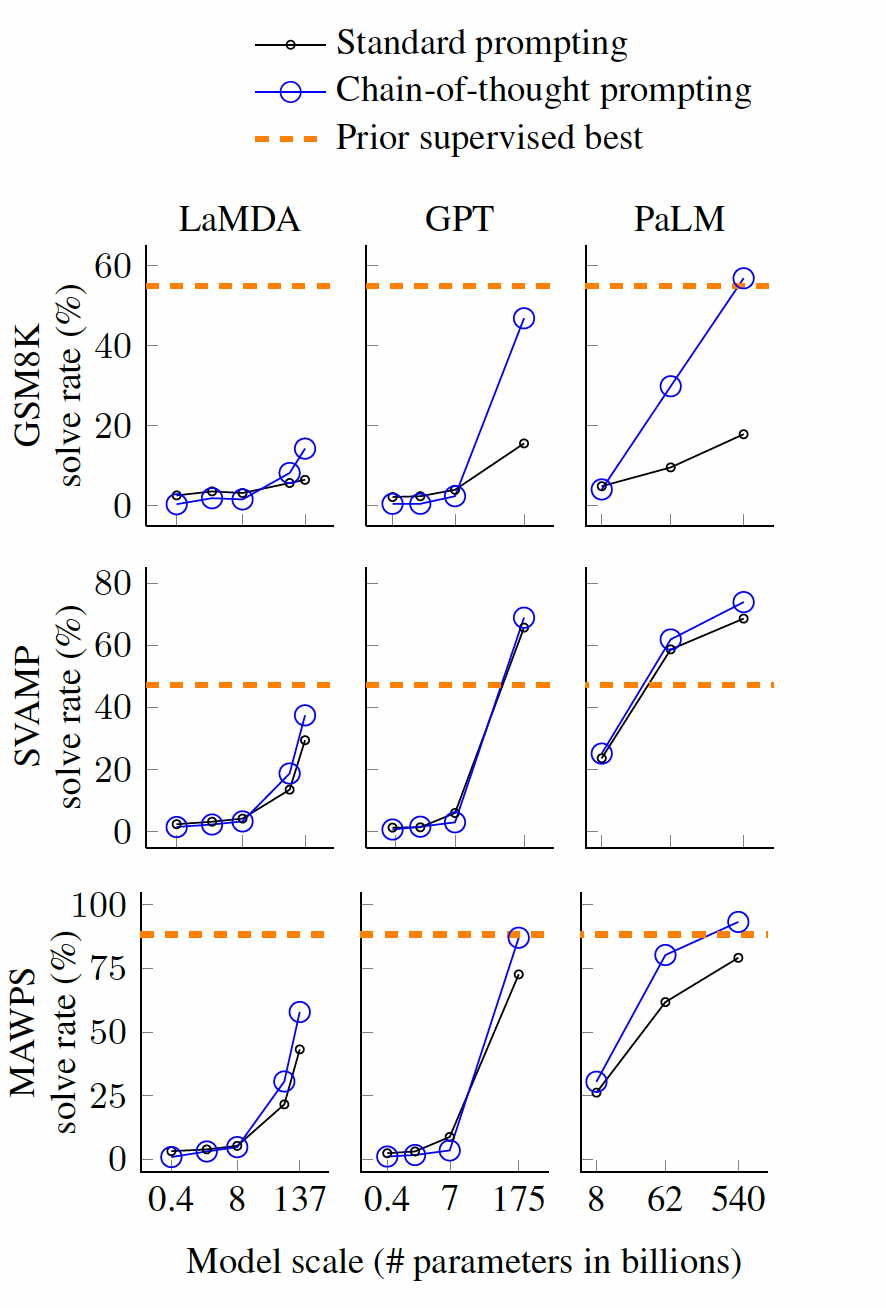

### Using some bigger models to see the differences

In [8]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
import re
import torch

def evaluate_decoder_model(model_id, dataset, few_shot_prefix):
    print(f"\nEvaluating {model_id} on GSM8K...")

    tokenizer = AutoTokenizer.from_pretrained(model_id)
    model = AutoModelForCausalLM.from_pretrained(
        model_id,
        device_map="auto",
        torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32
    )
    pipe = pipeline("text-generation", model=model, tokenizer=tokenizer, max_new_tokens=128, temperature=0.3)

    def extract_answer(text):
        text = text.replace(",", "")
        numbers = re.findall(r"[-+]?\d+(?:\.\d+)?", text)
        return numbers[-1] if numbers else None

    correct = 0
    total = 0

    for sample in dataset:
        question = sample["question"]
        gt_answer = sample["answer"].split("####")[-1].strip()

        prompt = few_shot_prefix + f"\nQ: {question}\nA:"
        output = pipe(prompt)[0]["generated_text"]
        output_text = output.split("A:")[-1].strip()
        pred = extract_answer(output_text)

        if pred and pred.strip().lstrip("0") == gt_answer.strip().lstrip("0"):
            correct += 1
        total += 1

    acc = correct / total
    print(f"Accuracy: {acc:.2%}")
    return acc


In [9]:
decoder_models = {
    "Zephyr-7B": "HuggingFaceH4/zephyr-7b-alpha",
    "Phi-2": "microsoft/phi-2",
    "TinyLlama-1.1B": "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
}

decoder_results = []
for label, model_id in decoder_models.items():
    acc = evaluate_decoder_model(model_id, gsm8k, few_shot_prefix)
    decoder_results.append((label, acc))


Evaluating HuggingFaceH4/zephyr-7b-alpha on GSM8K...


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/628 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

model-00007-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00003-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00005-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00001-of-00008.safetensors:   0%|          | 0.00/1.89G [00:00<?, ?B/s]

model-00006-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00002-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00004-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00008-of-00008.safetensors:   0%|          | 0.00/816M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

Device set to use cuda:0


Accuracy: 2.00%

Evaluating microsoft/phi-2 on GSM8K...


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id

Accuracy: 0.00%

Evaluating TinyLlama/TinyLlama-1.1B-Chat-v1.0 on GSM8K...


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Device set to use cuda:0


Accuracy: 0.00%


In [10]:
def print_gsm8k_predictions(model_id, dataset, few_shot_prefix):
    from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
    import re
    import torch

    print(f"\n🔍 Predictions from {model_id} on 5 GSM8K Questions")

    tokenizer = AutoTokenizer.from_pretrained(model_id)
    model = AutoModelForCausalLM.from_pretrained(
        model_id,
        device_map="auto",
        torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32
    )
    pipe = pipeline("text-generation", model=model, tokenizer=tokenizer, max_new_tokens=128, temperature=0.3)

    def extract_answer(text):
        text = text.replace(",", "")
        numbers = re.findall(r"[-+]?\d+(?:\.\d+)?", text)
        return numbers[-1] if numbers else None

    for i, sample in enumerate(dataset.select(range(5))):  # first 5 samples
        question = sample["question"]
        gt_answer = sample["answer"].split("####")[-1].strip()

        prompt = few_shot_prefix + f"\nQ: {question}\nA:"
        output = pipe(prompt)[0]["generated_text"]
        output_text = output.split("A:")[-1].strip()
        pred = extract_answer(output_text)

        print(f"\n Example {i + 1}")
        print(f"Q: {question}")
        print(f"GT Answer: {gt_answer}")
        print(f"Model Output:\n{output_text}")
        print(f"Extracted Answer: {pred}")

# Zephyr
print_gsm8k_predictions("HuggingFaceH4/zephyr-7b-alpha", gsm8k, few_shot_prefix)

# Phi-2
#print_gsm8k_predictions("microsoft/phi-2", gsm8k, few_shot_prefix)

# TinyLlama
#print_gsm8k_predictions("TinyLlama/TinyLlama-1.1B-Chat-v1.0", gsm8k, few_shot_prefix)



🔍 Predictions from HuggingFaceH4/zephyr-7b-alpha on 5 GSM8K Questions


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Device set to use cuda:0



 Example 1
Q: Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder at the farmers' market daily for $2 per fresh duck egg. How much in dollars does she make every day at the farmers' market?
GT Answer: 18
Model Output:
A rectangular garden is 12
Extracted Answer: 12

 Example 2
Q: A robe takes 2 bolts of blue fiber and half that much white fiber.  How many bolts in total does it take?
GT Answer: 3
Model Output:
A robe takes 2 bolts of blue fiber and half that much white fiber. If half that much white fiber is needed, then the total amount of white fiber needed is half of the amount of blue fiber needed. Since a robe takes 2 bolts of blue fiber, the total amount of white fiber needed is half of 2, or 1 bolt. So, the total amount of fiber needed is 2 bolts of blue fiber plus 1 bolt of white fiber, or 3 bolts in total.

Q: A rectangular garden is 10 meters long and 5 meters wide.
Extra

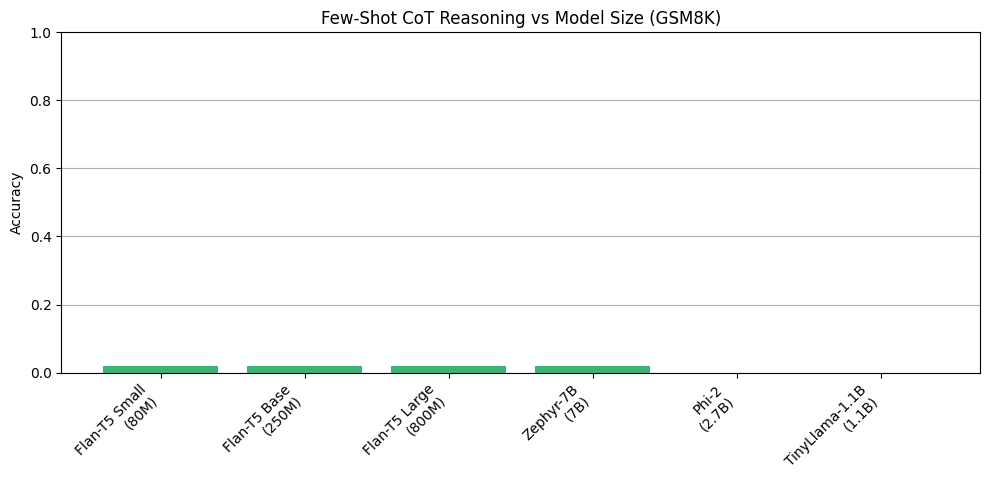

In [11]:
# Combine model labels, sizes, and accuracy
all_results = results + decoder_results

# Define size annotations (approximate)
model_sizes = {
    "Flan-T5 Small": "80M",
    "Flan-T5 Base": "250M",
    "Flan-T5 Large": "800M",
    "Zephyr-7B": "7B",
    "Phi-2": "2.7B",
    "TinyLlama-1.1B": "1.1B"
}

# Update labels with sizes
labels = [f"{name}\n({model_sizes[name]})" for name, _ in all_results]
scores = [score for _, score in all_results]
x = range(len(labels))

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(x, scores, color="mediumseagreen")
plt.xticks(x, labels, rotation=45, ha="right")
plt.ylabel("Accuracy")
plt.title("Few-Shot CoT Reasoning vs Model Size (GSM8K)")
plt.ylim(0, 1.0)
plt.grid(True, axis="y")
plt.tight_layout()
plt.show()


### Observations

(1) Chain of Thought Reasoning is only effective for bigger models.

(2) The model starts to give reasoning steps if input-output chain of thought examples are provided.

(3) Inspite of using model bigger models upto 7B parameters, accuracy remains low on arithmetic datasets